In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [191]:
from wm import Image as Image
from wm.moments import Moment2D
#from wm.moments import LegendreMoment
#from wm.moments import RadialHarmonicFourierMoment
from wm.moments import ZernikeMoment

In [169]:
from scipy import integrate

class ZernikeMoment(Moment2D):
    
    def __init__(self, n_max, N=None, **kwargs):
        super().__init__(n_max, N or n_max, **kwargs)
        #
        self.pseudo = kwargs.get('pseudo', False)
        self.qs = kwargs.get('qs', 1.2)  # quantization step
        self.encode_dir = kwargs.get('encode_dir', 'row')
        self.encode_K = kwargs.get('encode_K', self.m_max)
    
    def __call__(self, f_o, n=None, m=None, verbose=False):
        if n is not None and m is not None:
            if not self._correct_nm(n, m):
                return 0
            A_norm = (n+1) / self.pi
            A = 0
            for u in range(self.N):
                for v in range(self.M):
                    r, fi = f_o.pos_to_polar(u, v)
                    if r > 1:
                        continue
                    A += f_o(r, fi) * self.h(n, m, r, fi)
            return A_norm * A
        else:
            A = self.momentum_mx((self.n_max, 2*self.m_max+1))
            for n in range(self.n_max):
                if verbose: print(''.join([str(n),'/',str(self.n_max)])+' '*32, end='\r')
                for m in range(-self.m_max, self.m_max+1):
                    A[n,m] = self(f_o, n, m)
            return A
    
    def h(self, n, m, r, fi):
        du = 2 / self.N
        dv = 2 / self.M
        return self.conj(self.V(n, m, r, fi)) * du * dv
        #return integrate.dblquad(
        #    lambda x, y, n=n,m=m: self.conj(self.V(n, m, x, y)),
        #    x_u-du/2, x_u+du/2,
        #    y_v-dv/2, y_v+dv/2
        #)
    
    def R_ZM(self, n, m, r):
        res = 0
        m_abs = self.abs(m)
        for s in range((n-m_abs)//2+1):
            d0 = self.factorial(s)
            d1 = self.factorial((n+m_abs)//2-s)
            d2 = self.factorial((n-m_abs)//2-s)
            denom = d0 * d1 * d2
            res += ((-1.)**s) * self.factorial(n-s) * (r**(n-2*s)) / denom
        return res
    
    def R_PZM(self, n, m, r):
        res = 0
        m_abs = self.abs(m)
        for s in range(n-m_abs+1):
            d0 = self.factorial(s)
            d1 = self.factorial(n+m_abs+1-s)
            d2 = self.factorial(n-m_abs-s)
            denom = d0 * d1 * d2
            res += ((-1.)**s) * self.factorial(2*n+1-s) * (r**(n-s)) / denom
        return res
    
    def R(self, n, m, r):
        if not self._correct_nm(n, m):
            return 0
        if not self.pseudo:
            return self.R_ZM(n, m, r)
        else:
            return self.R_PZM(n, m, r)
    
    def V(self, n, m, r, fi):
        return self.R(n, m, r) * self.exp(self.i*m*fi)
    
    def _correct_nm(self, n, m):
        m_abs = self.abs(m)
        return (m_abs <= n) and (self.pseudo or (n-m_abs) % 2 == 0)
    
    def moment_from_encode_pos(self, p):
        K = self.encode_K
        if self.encode_dir == 'row':
            s = -1
            for n in range(self.n_max):
                for m in range(n+1):
                    if self._correct_nm(n, m) and m % 4 != 0:
                        s += 1
                        if s == p:
                            return (n, m)
        elif self.encode_dir == 'diagonal':
            s = -1
            for d in range(2,2*min(self.n_max,self.m_max),2):
                for e in range(d//2, d+1):
                    (n, m) = (e, d-e)
                    if self._correct_nm(n, m) and m % 4 != 0:
                        s += 1
                        if s == p:
                            return (n, m)
        else:
            return None
    
    def moments_from_encode_poss(self, pos):
        pos_nm = []
        if isinstance(pos, int):
            pos = list(range(pos))
        for p in pos:
            if isinstance(p, tuple):
                pos_nm.append(p)
            else:
                pos_nm.append(self.moment_from_encode_pos(p))
        return pos_nm
    
    def reconstruct(self, A, width, height=None, verbose=False):
        height = height or width
        colored = False
        I = Image(np.zeros((width,height), dtype=np.uint8), colored=colored)
        for u in range(width):
            if verbose: print(''.join([str(u*height),'/',str(width*height)])+' '*32, end='\r')
            for v in range(height):
                r, fi = I.pos_to_polar(u, v)
                if r > 1: continue
                a = 0
                for n in range(self.n_max):
                    for m in range(-self.m_max, self.m_max+1):
                        a += A[n,m] * self.V(n, m, r, fi)
                I.im[u,v] = self.pxtype(a)
        return Image(I.im, colored=colored)
    
    def d(self, m, i=0):
        d0 = self.qs
        d1 = self.qs / 2 + d0
        return d1 if m else d0
    
    def encode(self, f_o, w=None, pos=None, verbose=False):
        # choose moments to modify
        pos_nm = self.moments_from_encode_poss( pos or len(w) )
        if self.w_space < len(pos_nm):
            print('ERR: not enough moments')
            return None
        # (P)ZMs
        if verbose: print('1/4: moments'+' '*32, end='\r')
        F = self(f_o, verbose=verbose)
        # Reconstruction with unmodified RHFMs
        if verbose: print('2/4: reconstruction'+' '*32, end='\r')
        R = self.reconstruct(F, f_o.width, f_o.height, verbose=verbose).im
        D = f_o.im - R
        # modify
        #if verbose: print('3/4: encoding'+' '*32, end='\r')
        for k in range(len(w)):
            (n, m) = pos_nm[k]
            F_nm_abs = self.abs(F[n,m])
            l_k = np.round(F_nm_abs / self.qs)
            d = -1/2 if ((l_k + w[k]) % 2 == 1) else 1/2
            F_nm_abs_mod = (l_k + d) * self.qs
            F[n,m] = (F_nm_abs_mod / F_nm_abs) * F[n,m]
            F[n,-m] = (F_nm_abs_mod / F_nm_abs) * F[n,-m]
        # Reconstruction with modified RHFMs
        if verbose: print('4/4: modified reconstruction'+' '*32, end='\r')
        E = self.reconstruct(F, f_o.width, f_o.height, verbose=verbose).im
        # Image combination
        if verbose: print('done'+' '*32, end='\r')
        return Image(E + D, colored=f_o.colored)
    
    def decode(self, f_o, pos=None, verbose=False):
        # choose moments to decode
        pos_nm = self.moments_from_encode_poss( pos ) # or ((self.n_max+self.m_max)//2) )
        if self.w_space < len(pos_nm):
            print('ERR: not enough moments')
            return None
        # Modified RHFMs
        F = self(f_o, verbose=verbose)
        # decode
        w = []
        for (n, m) in pos_nm:
            F_nm_abs = self.abs(F[n,m])
            l_k = np.floor(F_nm_abs / self.qs)
            w_k = int(l_k % 2)
            #print(n, m, abs(F[n,m]), np.floor(F_nm_abs / self.qs), w_k)
            w.append(w_k)
        if verbose: print('done'+' '*32, end='\r')
        return w
    

In [202]:
N = 32
order = 8
#
im = Image('lena_'+str(N)+'.png', circle_radius=1)
ZM = ZernikeMoment(order, N, encode_dir='row')

In [198]:
w = np.random.randint(2, size=8)
p = range(len(w))
E = ZM.encode(im.grey, w, p, verbose=True)

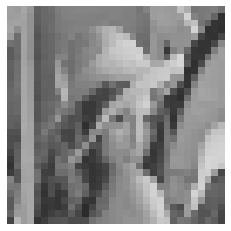

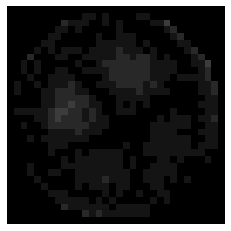

In [199]:
E.show()
imdiff = np.abs(im.grey.im.astype('float16') - E.im.astype('float16')).astype('uint16')
# imdiffmax = np.max(imdiff)
II = Image(20*imdiff, colored=False)
II.show()

In [200]:
ZM.decode(E, pos=p, verbose=True)

[0, 0, 1, 0, 0, 1, 0, 1]

In [201]:
w

array([0, 0, 1, 0, 0, 1, 0, 1])

In [ ]:
#%%time
F = ZM(im.grey, verbose=True)

In [ ]:
F[4]

In [ ]:
#%%time
I = ZM.reconstruct(F, N, verbose=True)
I.show()

In [ ]:
list(zip(w, RHFM.decode(E, p)))